# Building and Evaluating Normative Encoding Models


In [1]:
# Imports
import numpy as np
from scipy.stats import zscore
import matplotlib as mpl
from matplotlib import pyplot as plt

import torch
from torch import nn, optim
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [4]:
# @title Figure Settings
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

%config InlineBackend.figure_format = 'retina'
plt.style.use("/Users/benchen/NeuralHub/Neuromatch/NM_DL_custom_plot_style.mplstyle")

In [5]:
# @title Plotting Functions

def show_stimulus(img, ax=None, show=False):
  """Visualize a stimulus"""
  if ax is None:
    ax = plt.gca()
  ax.imshow(img, cmap=mpl.cm.binary)
  ax.set_aspect('auto')
  ax.set_xticks([])
  ax.set_yticks([])
  ax.spines['left'].set_visible(False)
  ax.spines['bottom'].set_visible(False)
  if show:
    plt.show()


def plot_corr_matrix(rdm, ax=None, show=False):
  """Plot dissimilarity matrix

  Args:
    rdm (numpy array): n_stimuli x n_stimuli representational dissimilarity
      matrix
    ax (matplotlib axes): axes onto which to plot

  Returns:
    nothing

  """
  if ax is None:
    ax = plt.gca()
  image = ax.imshow(rdm, vmin=0.0, vmax=2.0)
  ax.set_xticks([])
  ax.set_yticks([])
  cbar = plt.colorbar(image, ax=ax, label='dissimilarity')
  if show:
    plt.show()


def plot_multiple_rdm(rdm_dict):
  """Draw multiple subplots for each RDM in rdm_dict."""
  fig, axs = plt.subplots(1, len(rdm_dict),
                          figsize=(4 * len(resp_dict), 3.5))

  # Compute RDM's for each set of responses and plot
  for i, (label, rdm) in enumerate(rdm_dict.items()):

    image = plot_corr_matrix(rdm, axs[i])
    axs[i].set_title(label)
  plt.show()


def plot_rdm_rdm_correlations(rdm_sim):
  """Draw a bar plot showing between-RDM correlations."""
  f, ax = plt.subplots()
  ax.bar(rdm_sim.keys(), rdm_sim.values())
  ax.set_xlabel('Deep network model layer')
  ax.set_ylabel('Correlation of model layer RDM\nwith mouse V1 RDM')
  plt.show()


def plot_rdm_rows(ori_list, rdm_dict, rdm_oris):
  """Plot the dissimilarity of response to each stimulus with response to one
  specific stimulus

  Args:
    ori_list (list of float): plot dissimilarity with response to stimulus with
      orientations closest to each value in this list
    rdm_dict (dict): RDM's from which to extract dissimilarities
    rdm_oris (np.ndarray): orientations corresponding to each row/column of RDMs
    in rdm_dict

  """
  n_col = len(ori_list)
  f, axs = plt.subplots(1, n_col, figsize=(4 * n_col, 4), sharey=True)

  # Get index of orientation closest to ori_plot
  for ax, ori_plot in zip(axs, ori_list):
    iori = np.argmin(np.abs(rdm_oris - ori_plot))

    # Plot dissimilarity curves in each RDM
    for label, rdm in rdm_dict.items():
      ax.plot(rdm_oris, rdm[iori, :], label=label)

    # Draw vertical line at stimulus we are plotting dissimilarity w.r.t.
    ax.axvline(rdm_oris[iori], color=".7", zorder=-1)

    # Label axes
    ax.set_title(f'Dissimilarity with response\nto {ori_plot: .0f}$^o$ stimulus')
    ax.set_xlabel('Stimulus orientation ($^o$)')

  axs[0].set_ylabel('Dissimilarity')
  axs[-1].legend(loc="upper left", bbox_to_anchor=(1, 1))
  plt.tight_layout()
  plt.show()

In [6]:
# @title Helper Functions

def load_data(data_name, bin_width=1):
  """Load mouse V1 data from Stringer et al. (2019)

  Data from study reported in this preprint:
  https://www.biorxiv.org/content/10.1101/679324v2.abstract

  These data comprise time-averaged responses of ~20,000 neurons
  to ~4,000 stimulus gratings of different orientations, recorded
  through Calcium imaginge. The responses have been normalized by
  spontaneous levels of activity and then z-scored over stimuli, so
  expect negative numbers. They have also been binned and averaged
  to each degree of orientation.

  This function returns the relevant data (neural responses and
  stimulus orientations) in a torch.Tensor of data type torch.float32
  in order to match the default data type for nn.Parameters in
  Google Colab.

  This function will actually average responses to stimuli with orientations
  falling within bins specified by the bin_width argument. This helps
  produce individual neural "responses" with smoother and more
  interpretable tuning curves.

  Args:
    bin_width (float): size of stimulus bins over which to average neural
      responses

  Returns:
    resp (torch.Tensor): n_stimuli x n_neurons matrix of neural responses,
        each row contains the responses of each neuron to a given stimulus.
        As mentioned above, neural "response" is actually an average over
        responses to stimuli with similar angles falling within specified bins.
    stimuli: (torch.Tensor): n_stimuli x 1 column vector with orientation
        of each stimulus, in degrees. This is actually the mean orientation
        of all stimuli in each bin.

  """
  with np.load(data_name) as dobj:
    data = dict(**dobj)
  resp = data['resp']
  stimuli = data['stimuli']

  if bin_width > 1:
    # Bin neural responses and stimuli
    bins = np.digitize(stimuli, np.arange(0, 360 + bin_width, bin_width))
    stimuli_binned = np.array([stimuli[bins == i].mean() for i in np.unique(bins)])
    resp_binned = np.array([resp[bins == i, :].mean(0) for i in np.unique(bins)])
  else:
    resp_binned = resp
    stimuli_binned = stimuli

  # only use stimuli <= 180
  resp_binned = resp_binned[stimuli_binned <= 180]
  stimuli_binned = stimuli_binned[stimuli_binned <= 180]

  stimuli_binned -= 90  # 0 means vertical, -ve means tilted left, +ve means tilted right

  # Return as torch.Tensor
  resp_tensor = torch.tensor(resp_binned, dtype=torch.float32)
  stimuli_tensor = torch.tensor(stimuli_binned, dtype=torch.float32).unsqueeze(1)  # add singleton dimension to make a column vector

  return resp_tensor, stimuli_tensor


def grating(angle, sf=1 / 28, res=0.1, patch=False):
  """Generate oriented grating stimulus

  Args:
    angle (float): orientation of grating (angle from vertical), in degrees
    sf (float): controls spatial frequency of the grating
    res (float): resolution of image. Smaller values will make the image
      smaller in terms of pixels. res=1.0 corresponds to 640 x 480 pixels.
    patch (boolean): set to True to make the grating a localized
      patch on the left side of the image. If False, then the
      grating occupies the full image.

  Returns:
    torch.Tensor: (res * 480) x (res * 640) pixel oriented grating image

  """

  angle = np.deg2rad(angle)  # transform to radians

  wpix, hpix = 640, 480  # width and height of image in pixels for res=1.0

  xx, yy = np.meshgrid(sf * np.arange(0, wpix * res) / res, sf * np.arange(0, hpix * res) / res)

  if patch:
    gratings = np.cos(xx * np.cos(angle + .1) + yy * np.sin(angle + .1))  # phase shift to make it better fit within patch
    gratings[gratings < 0] = 0
    gratings[gratings > 0] = 1
    xcent = gratings.shape[1] * .75
    ycent = gratings.shape[0] / 2
    xxc, yyc = np.meshgrid(np.arange(0, gratings.shape[1]), np.arange(0, gratings.shape[0]))
    icirc = ((xxc - xcent) ** 2 + (yyc - ycent) ** 2) ** 0.5 < wpix / 3 / 2 * res
    gratings[~icirc] = 0.5

  else:
    gratings = np.cos(xx * np.cos(angle) + yy * np.sin(angle))
    gratings[gratings < 0] = 0
    gratings[gratings > 0] = 1

  # Return torch tensor
  return torch.tensor(gratings, dtype=torch.float32)


def filters(out_channels=6, K=7):
  """ make example filters, some center-surround and gabors
  Returns:
      filters: out_channels x K x K
  """
  grid = np.linspace(-K/2, K/2, K).astype(np.float32)
  xx,yy = np.meshgrid(grid, grid, indexing='ij')

  # create center-surround filters
  sigma = 1.1
  gaussian = np.exp(-(xx**2 + yy**2)**0.5/(2*sigma**2))
  wide_gaussian = np.exp(-(xx**2 + yy**2)**0.5/(2*(sigma*2)**2))
  center_surround = gaussian - 0.5 * wide_gaussian

  # create gabor filters
  thetas = np.linspace(0, 180, out_channels-2+1)[:-1] * np.pi/180
  gabors = np.zeros((len(thetas), K, K), np.float32)
  lam = 10
  phi = np.pi/2
  gaussian = np.exp(-(xx**2 + yy**2)**0.5/(2*(sigma*0.4)**2))
  for i,theta in enumerate(thetas):
    x = xx*np.cos(theta) + yy*np.sin(theta)
    gabors[i] = gaussian * np.cos(2*np.pi*x/lam + phi)

  filters = np.concatenate((center_surround[np.newaxis,:,:],
                            -1*center_surround[np.newaxis,:,:],
                            gabors),
                           axis=0)
  filters /= np.abs(filters).max(axis=(1,2))[:,np.newaxis,np.newaxis]
  # convert to torch
  filters = torch.from_numpy(filters)
  # add channel axis
  filters = filters.unsqueeze(1)

  return filters


class CNN(nn.Module):
  """Deep convolutional network with one convolutional + pooling layer followed
  by one fully connected layer

  Args:
    h_in (int): height of input image, in pixels (i.e. number of rows)
    w_in (int): width of input image, in pixels (i.e. number of columns)

  Attributes:
    conv (nn.Conv2d): filter weights of convolutional layer
    pool (nn.MaxPool2d): max pooling layer
    dims (tuple of ints): dimensions of output from pool layer
    fc (nn.Linear): weights and biases of fully connected layer
    out (nn.Linear): weights and biases of output layer

  """

  def __init__(self, h_in, w_in):
    super().__init__()
    C_in = 1  # input stimuli have only 1 input channel
    C_out = 6  # number of output channels (i.e. of convolutional kernels to convolve the input with)
    K = 7  # size of each convolutional kernel
    Kpool = 8  # size of patches over which to pool
    self.conv = nn.Conv2d(C_in, C_out, kernel_size=K, padding=K//2)  # add padding to ensure that each channel has same dimensionality as input
    self.pool = nn.MaxPool2d(Kpool)
    self.dims = (C_out, h_in // Kpool, w_in // Kpool)  # dimensions of pool layer output
    self.fc = nn.Linear(np.prod(self.dims), 10)  # flattened pool output --> 10D representation
    self.out = nn.Linear(10, 1)  # 10D representation --> scalar
    self.conv.weight = nn.Parameter(filters(C_out, K))
    self.conv.bias = nn.Parameter(torch.zeros((C_out,), dtype=torch.float32))

  def forward(self, x):
    """Classify grating stimulus as tilted right or left

    Args:
      x (torch.Tensor): p x 48 x 64 tensor with pixel grayscale values for
          each of p stimulus images.

    Returns:
      torch.Tensor: p x 1 tensor with network outputs for each input provided
          in x. Each output should be interpreted as the probability of the
          corresponding stimulus being tilted right.

    """
    x = x.unsqueeze(1)  # p x 1 x 48 x 64, add a singleton dimension for the single stimulus channel
    x = torch.relu(self.conv(x))  # output of convolutional layer
    x = self.pool(x)  # output of pooling layer
    x = x.view(-1, np.prod(self.dims))  # flatten pooling layer outputs into a vector
    x = torch.relu(self.fc(x))  # output of fully connected layer
    x = torch.sigmoid(self.out(x))  # network output
    return x


def train(net, train_data, train_labels,
          n_epochs=25, learning_rate=0.0005,
          batch_size=100, momentum=.99):
  """Run stochastic gradient descent on binary cross-entropy loss for a given
  deep network (cf. appendix for details)

  Args:
    net (nn.Module): deep network whose parameters to optimize with SGD
    train_data (torch.Tensor): n_train x h x w tensor with stimulus gratings
    train_labels (torch.Tensor): n_train x 1 tensor with true tilt of each
      stimulus grating in train_data, i.e. 1. for right, 0. for left
    n_epochs (int): number of times to run SGD through whole training data set
    batch_size (int): number of training data samples in each mini-batch
    learning_rate (float): learning rate to use for SGD updates
    momentum (float): momentum parameter for SGD updates

  """

  # Initialize binary cross-entropy loss function
  loss_fn = nn.BCELoss()

  # Initialize SGD optimizer with momentum
  optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)

  # Placeholder to save loss at each iteration
  track_loss = []

  # Loop over epochs
  for i in range(n_epochs):

    # Split up training data into random non-overlapping mini-batches
    ishuffle = torch.randperm(train_data.shape[0])  # random ordering of training data
    minibatch_data = torch.split(train_data[ishuffle], batch_size)  # split train_data into minibatches
    minibatch_labels = torch.split(train_labels[ishuffle], batch_size)  # split train_labels into minibatches

    # Loop over mini-batches
    for stimuli, tilt in zip(minibatch_data, minibatch_labels):

      # Evaluate loss and update network weights
      out = net(stimuli)  # predicted probability of tilt right
      loss = loss_fn(out, tilt)  # evaluate loss
      optimizer.zero_grad()  # clear gradients
      loss.backward()  # compute gradients
      optimizer.step()  # update weights

      # Keep track of loss at each iteration
      track_loss.append(loss.item())

    # Track progress
    if (i + 1) % (n_epochs // 5) == 0:
      print(f'epoch {i + 1} | loss on last mini-batch: {loss.item(): .2e}')

  print('training done!')


def get_hidden_activity(net, stimuli, layer_labels):
  """Retrieve internal representations of network

  Args:
    net (nn.Module): deep network
    stimuli (torch.Tensor): p x 48 x 64 tensor with stimuli for which to
      compute and retrieve internal representations
    layer_labels (list): list of strings with labels of each layer for which
      to return its internal representations

  Returns:
    dict: internal representations at each layer of the network, in
      numpy arrays. The keys of this dict are the strings in layer_labels.

  """

  # Placeholder
  hidden_activity = {}

  # Attach 'hooks' to each layer of the network to store hidden
  # representations in hidden_activity
  def hook(module, input, output):
    module_label = list(net._modules.keys())[np.argwhere([module == m for m in net._modules.values()])[0, 0]]
    if module_label in layer_labels:  # ignore output layer
      hidden_activity[module_label] = output.view(stimuli.shape[0], -1).detach().numpy()
  hooks = [layer.register_forward_hook(hook) for layer in net.children()]

  # Run stimuli through the network
  pred = net(stimuli)

  # Remove the hooks
  [h.remove() for h in hooks]

  return hidden_activity

In [11]:
#@title Data retrieval and loading
import os
import hashlib
import requests

fname = "W3D4_stringer_oribinned1.npz"
url = "https://osf.io/683xc/download"
expected_md5 = "436599dfd8ebe6019f066c38aed20580"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    elif hashlib.md5(r.content).hexdigest() != expected_md5:
      print("!!! Data download appears corrupted !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

## Using Deep Neural Network to carry out orientation discrimination task

In [8]:
help(train)

Help on function train in module __main__:

train(net, train_data, train_labels, n_epochs=25, learning_rate=0.0005, batch_size=100, momentum=0.99)
    Run stochastic gradient descent on binary cross-entropy loss for a given
    deep network (cf. appendix for details)
    
    Args:
      net (nn.Module): deep network whose parameters to optimize with SGD
      train_data (torch.Tensor): n_train x h x w tensor with stimulus gratings
      train_labels (torch.Tensor): n_train x 1 tensor with true tilt of each
        stimulus grating in train_data, i.e. 1. for right, 0. for left
      n_epochs (int): number of times to run SGD through whole training data set
      batch_size (int): number of training data samples in each mini-batch
      learning_rate (float): learning rate to use for SGD updates
      momentum (float): momentum parameter for SGD updates



**Finding out the input image size that you feed into the CNN**<br>
Yes, you should match the input size of your CNN to the actual size of the images produced by your grating() function.

However, your grating() function uses a default res=0.1, so the output image shape is:

height: hpix * res = 480 * 0.1 = 48
width: wpix * res = 640 * 0.1 = 64
So, if you use the default res=0.1, your images are 48 x 64, and your current h, w = 48, 64 is correct.

If you change res to 1.0, then your images will be 480 x 640, and you should set:

Summary:

If you use grating(..., res=0.1), keep h, w = 48, 64.
If you use grating(..., res=1.0), set h, w = 480, 640.
Always set h, w to match the actual shape of your input images.

In [14]:
# Training the CNN

# Set random seeds for reproducibility
np.random.seed(12)
torch.manual_seed(12)

h, w = 48, 64  # Define image height and width

# Initialize CNN model
net = CNN(h, w)

# Build training set to train it on
n_train = 1000  # size of training set

# sample n_train random orientations between -90 and +90 degrees
ori = (np.random.rand(n_train) - 0.5) * 180

# build orientated grating stimuli
stimuli = torch.stack([grating(i) for i in ori])

# stimulus tilt: 1. if tilted right, 0. if tilted left, as a column vector
tilt = torch.tensor(ori > 0).type(torch.float).unsqueeze(-1)

# Train model
train(net, stimuli, tilt)

epoch 5 | loss on last mini-batch:  4.10e-01
epoch 10 | loss on last mini-batch:  5.17e-02
epoch 15 | loss on last mini-batch:  1.32e-02
epoch 20 | loss on last mini-batch:  2.27e-03
epoch 25 | loss on last mini-batch:  8.15e-05
training done!


### Loading data
**Data from Stringer et al. 2021, which contain responses of about 20,000 neurons from mouse primary visual cortex to grading stimuli**<br>
* `resp_v1` is a matrix where each row contains the responses of all neurons to a single stimulus.
* `ori` is a vector with the orientations of each stimulus, in degrees. As in the above convention, negative angles denote stimuli tilted to the left and positive angles denote stimuli tilted to the right.



In [15]:
# Load mouse V1 data
resp_v1, ori = load_data(fname)

# Extract model internal representations of each stimulus in the V1 data
# construct grating stimuli for each orientation presented in the V1 data
stimuli = torch.stack([grating(a.item()) for a in ori])
layer_labels = ['pool', 'fc']
resp_model = get_hidden_activity(net, stimuli, layer_labels)

# Aggregate all responses into one dict
resp_dict = {}
resp_dict['V1 data'] = resp_v1
for k, v in resp_model.items():
  label = f"model\n'{k}' layer"
  resp_dict[label] = v

In [19]:
print(resp_dict)

{'V1 data': tensor([[ 0.0815, -0.2952, -0.0701,  ...,  0.2920, -0.2144,  0.8902],
        [-0.0226,  0.0798, -0.1131,  ..., -0.0151,  0.0521,  0.2004],
        [ 0.1668,  0.0034, -0.1502,  ..., -0.3936,  0.2092,  0.5552],
        ...,
        [-0.1674,  0.7014, -0.1700,  ..., -0.1914, -0.4036,  1.1963],
        [ 0.1824, -0.1861, -0.1190,  ..., -0.4624,  0.1725,  1.6199],
        [-0.2975, -0.3778, -0.1289,  ..., -0.1546, -0.2093,  1.0442]]), "model\n'pool' layer": array([[0.92165554, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.92165554, 0.        , 0.        , ..., 0.        , 0.        ,
        0.17562407],
       [0.92165554, 0.        , 0.        , ..., 0.        , 0.        ,
        1.8895769 ],
       ...,
       [0.92165554, 0.28148192, 0.28148222, ..., 1.616811  , 1.6168109 ,
        1.7119687 ],
       [0.92165554, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.92165554, 0.        , 0.        , ...,

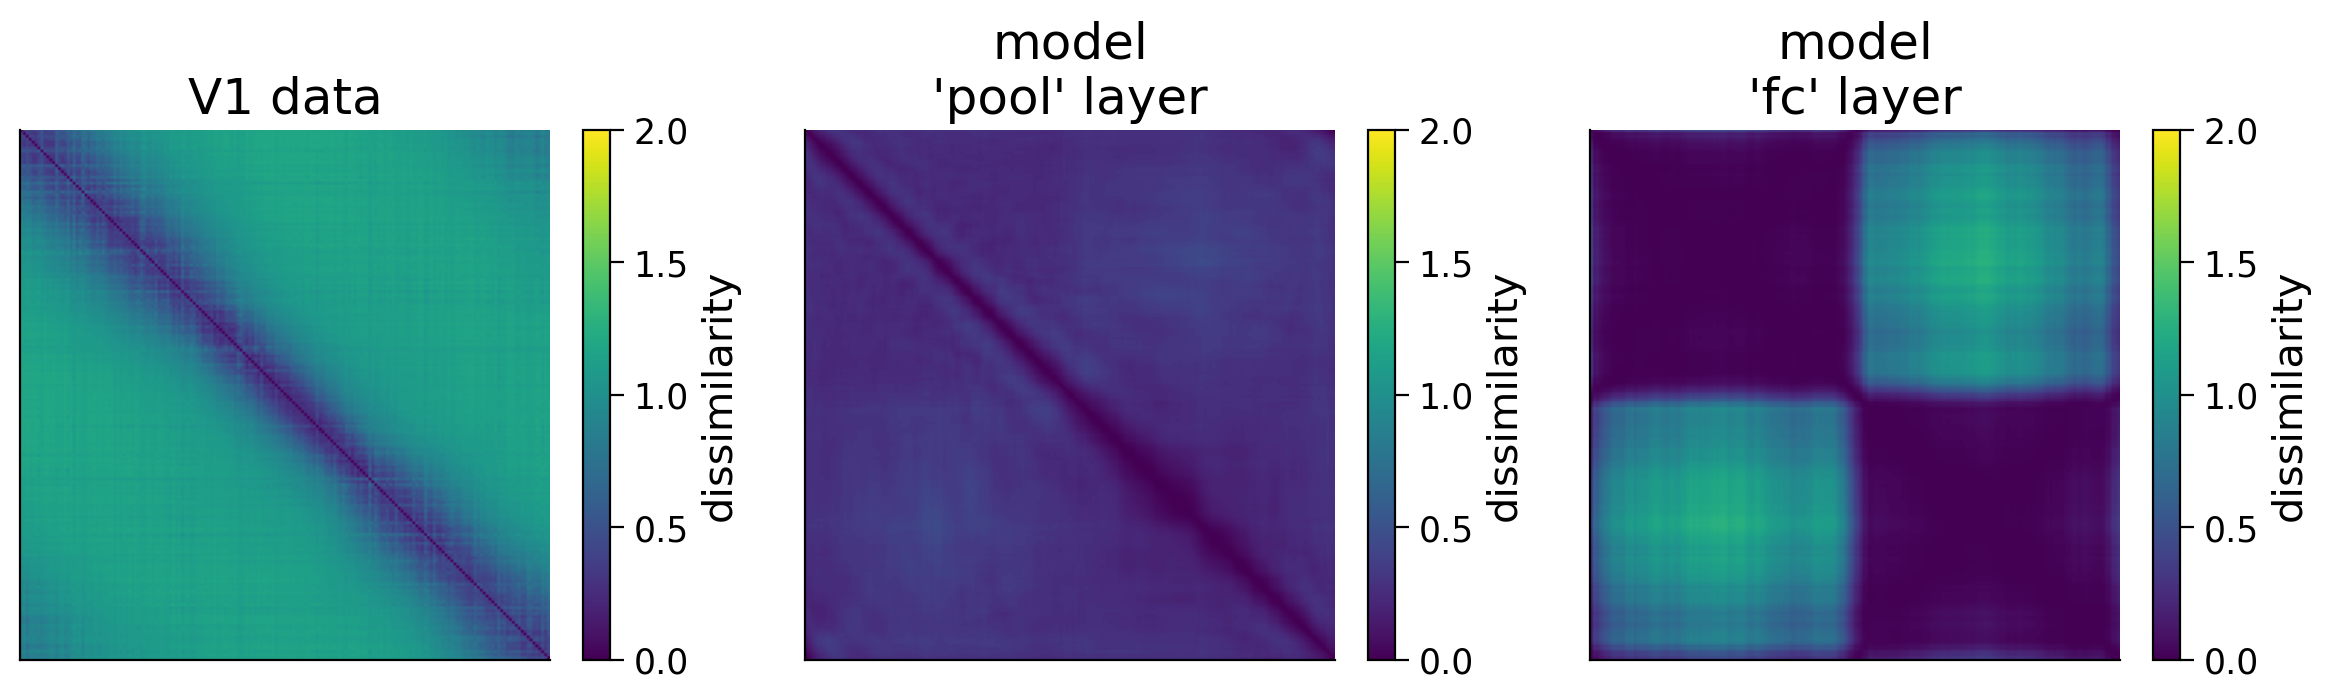

In [ ]:
def RDM(resp):
  """Compute the representational dissimilarity matrix (RDM)

  Args:
    resp (ndarray): S x N matrix with population responses to
      each stimulus in each row

  Returns:
    ndarray: S x S representational dissimilarity matrix
  """


  # z-score responses to each stimulus
  zresp = zscore(resp, axis=1)

  # Compute RDM
  RDM = 1 - (1/zresp.shape[1]) * zresp @ zresp.T 
  # .shape[1] help identify the number of columns
  # @ used for matrix multiplication, and .T used to trapose matrices

  return RDM


# Compute RDMs for each layer
rdm_dict = {label: RDM(resp) for label, resp in resp_dict.items()}

# Plot RDMs
plot_multiple_rdm(rdm_dict)

**Detailed description of the z-score response matrix, with r(s) rows, and N number of neurons/columns**<br>
$\begin{gather}
\mathbf{M} = 1 - \frac{1}{N} \mathbf{ZZ}^\top \\
\mathbf{Z} =
\begin{bmatrix}
z_1^{(1)} & z_2^{(1)} & \ldots & z_N^{(1)} \\
z_1^{(2)} & z_2^{(2)} & \ldots & z_N^{(2)} \\
\vdots & \vdots & \ddots & \vdots \\
z_1^{(S)} & z_2^{(S)} & \ldots & z_N^{(S)}
\end{bmatrix}
\end{gather}$

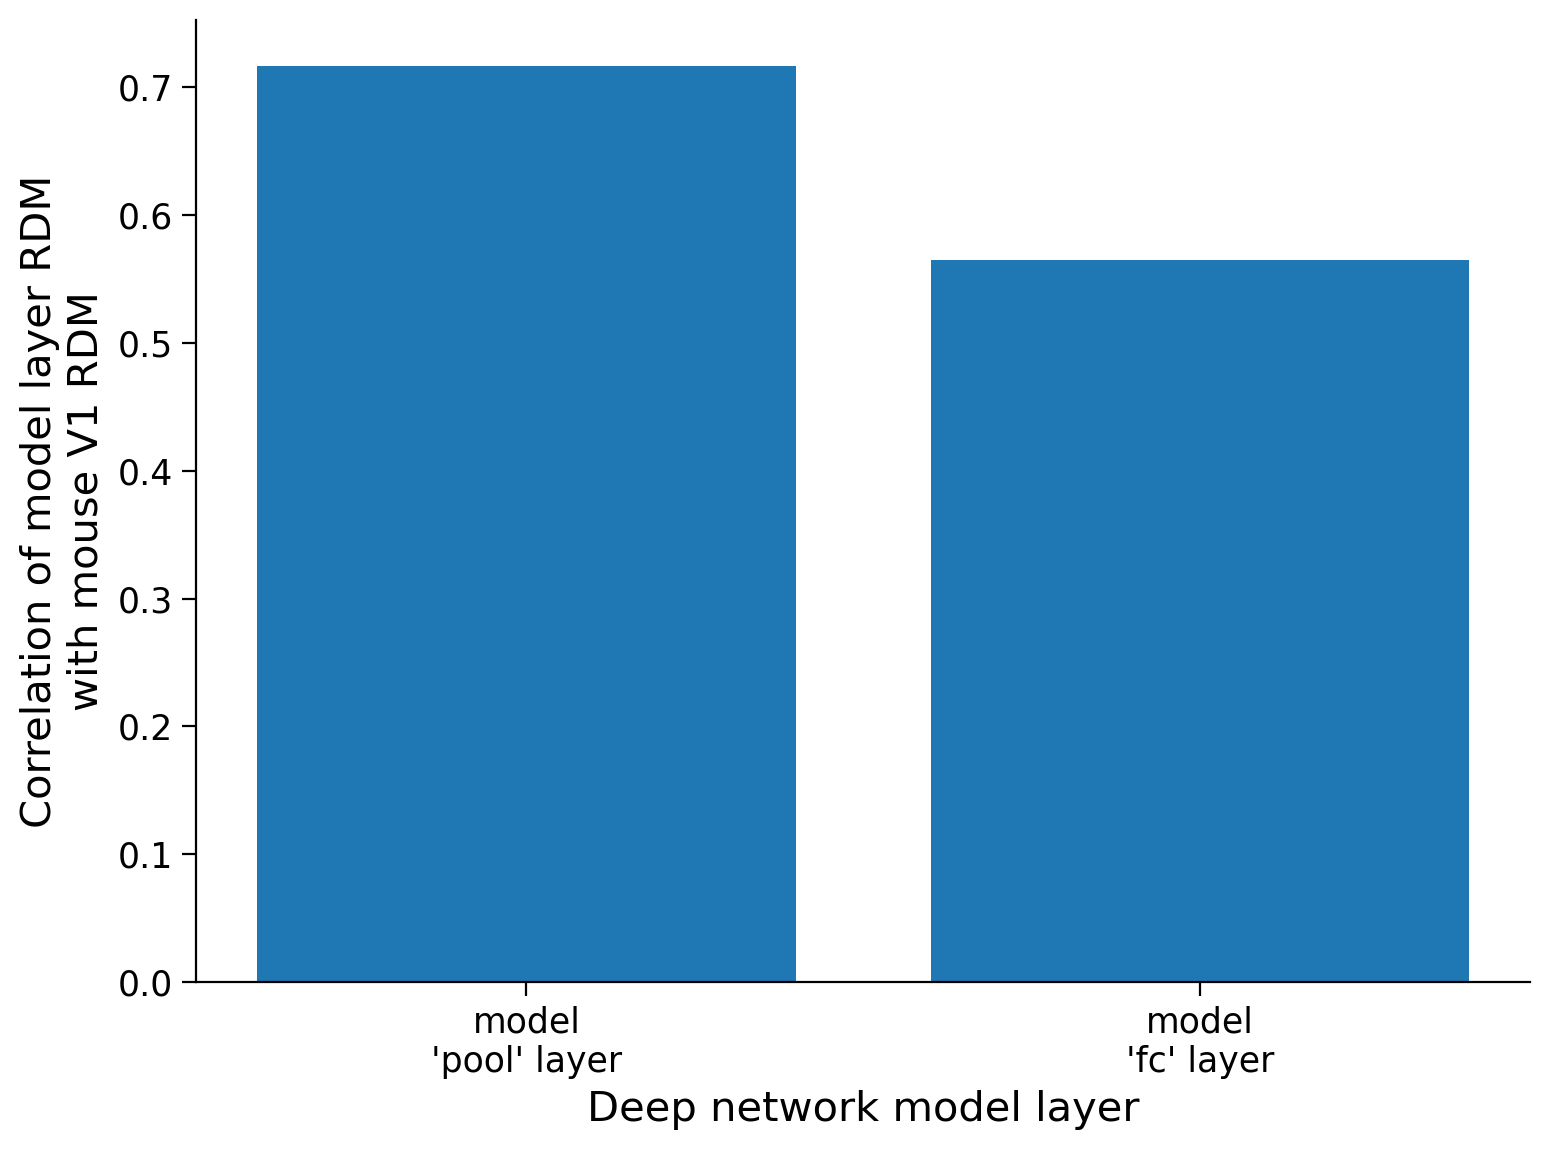

In [25]:
def correlate_rdms(rdm1, rdm2):
  """Correlate off-diagonal elements of two RDM's

  Args:
    rdm1 (np.ndarray): S x S representational dissimilarity matrix
    rdm2 (np.ndarray): S x S representational dissimilarity matrix to
      correlate with rdm1

  Returns:
    float: correlation coefficient between the off-diagonal elements
      of rdm1 and rdm2

  """

  # Extract off-diagonal elements of each RDM
  ioffdiag = np.triu_indices(rdm1.shape[0], k=1)  # indices of off-diagonal elements
  rdm1_offdiag = rdm1[ioffdiag]
  rdm2_offdiag = rdm2[ioffdiag]


  corr_coef = np.corrcoef(rdm1_offdiag, rdm2_offdiag)[0,1]

  return corr_coef


# Split RDMs into V1 responses and model responses
rdm_model = rdm_dict.copy()
rdm_v1 = rdm_model.pop('V1 data')

# Correlate off-diagonal terms of dissimilarity matrices
rdm_sim = {label: correlate_rdms(rdm_v1, rdm) for label, rdm in rdm_model.items()}

# Visualize
plot_rdm_rdm_correlations(rdm_sim)

#### Plottting individual rows of the RDM matrix 
The resulting curves show the similarity of the responses to each stimulus with that to one specific stimulus.

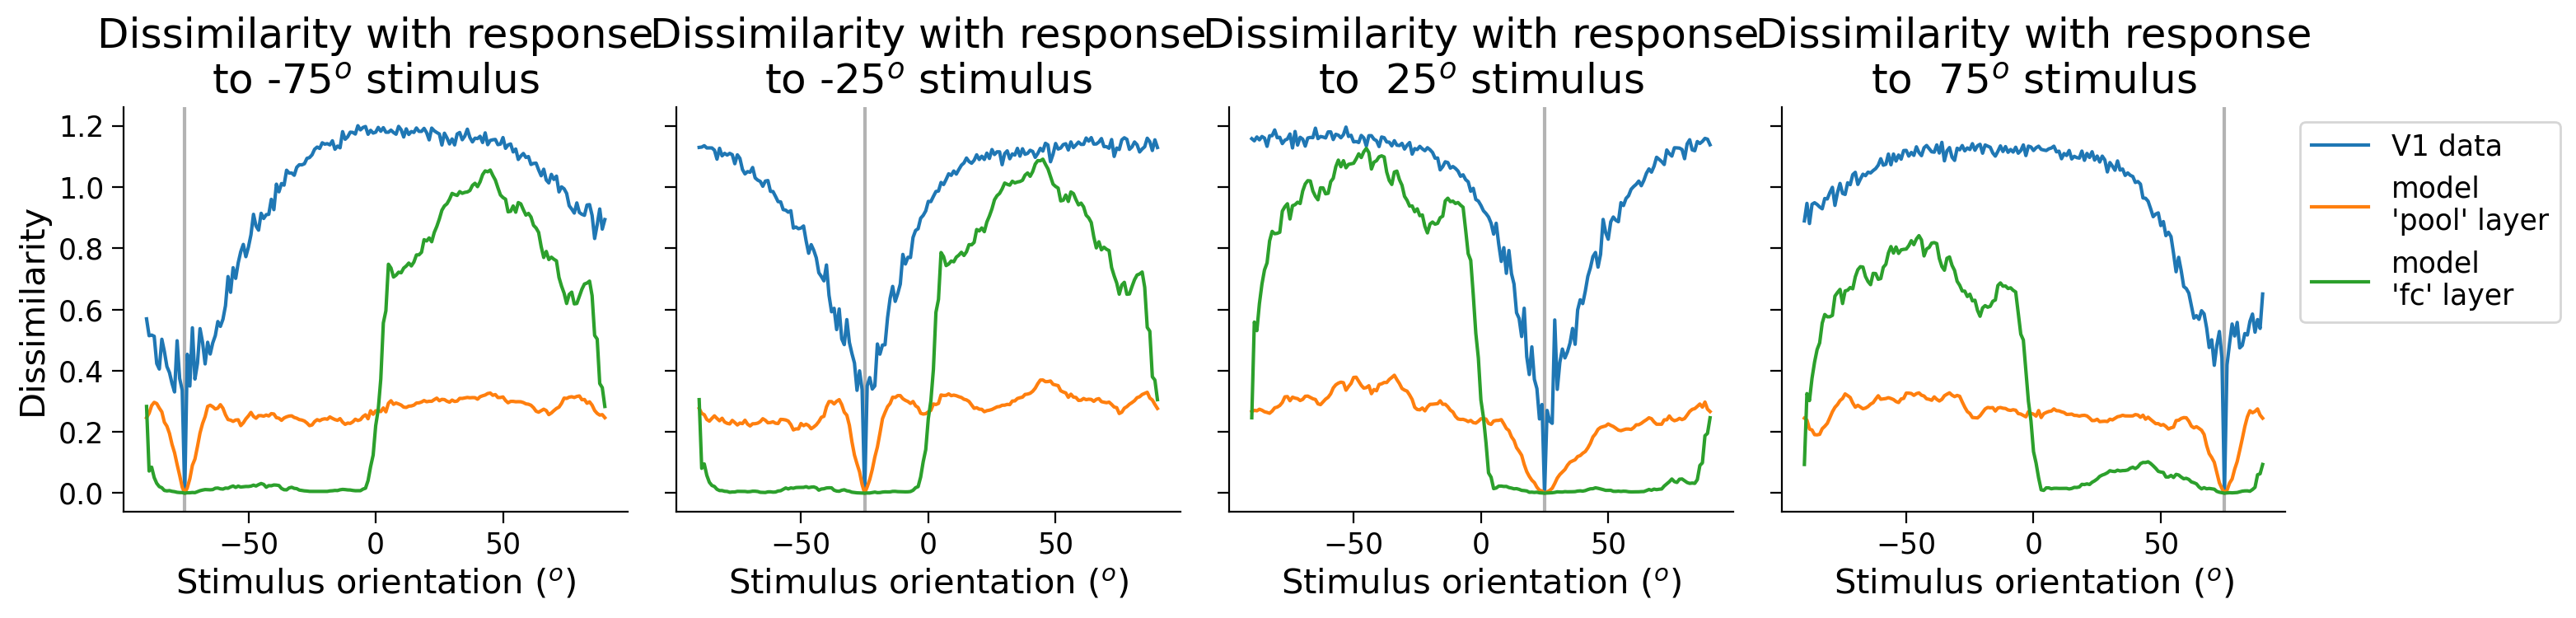

In [27]:
ori_list = [-75, -25, 25, 75]
plot_rdm_rows(ori_list, rdm_dict, ori.numpy())

### Qualitative comparisons of CNNs and neural activity
1. **Tunning curves:** Plotting the response of single neurons (or unit in deep network) as a function fo the stimulus orientation
2. **Dimensionality Reduction:** Plotting the full population responses to each stimulus in two dimensions via dimensionality reduction. 

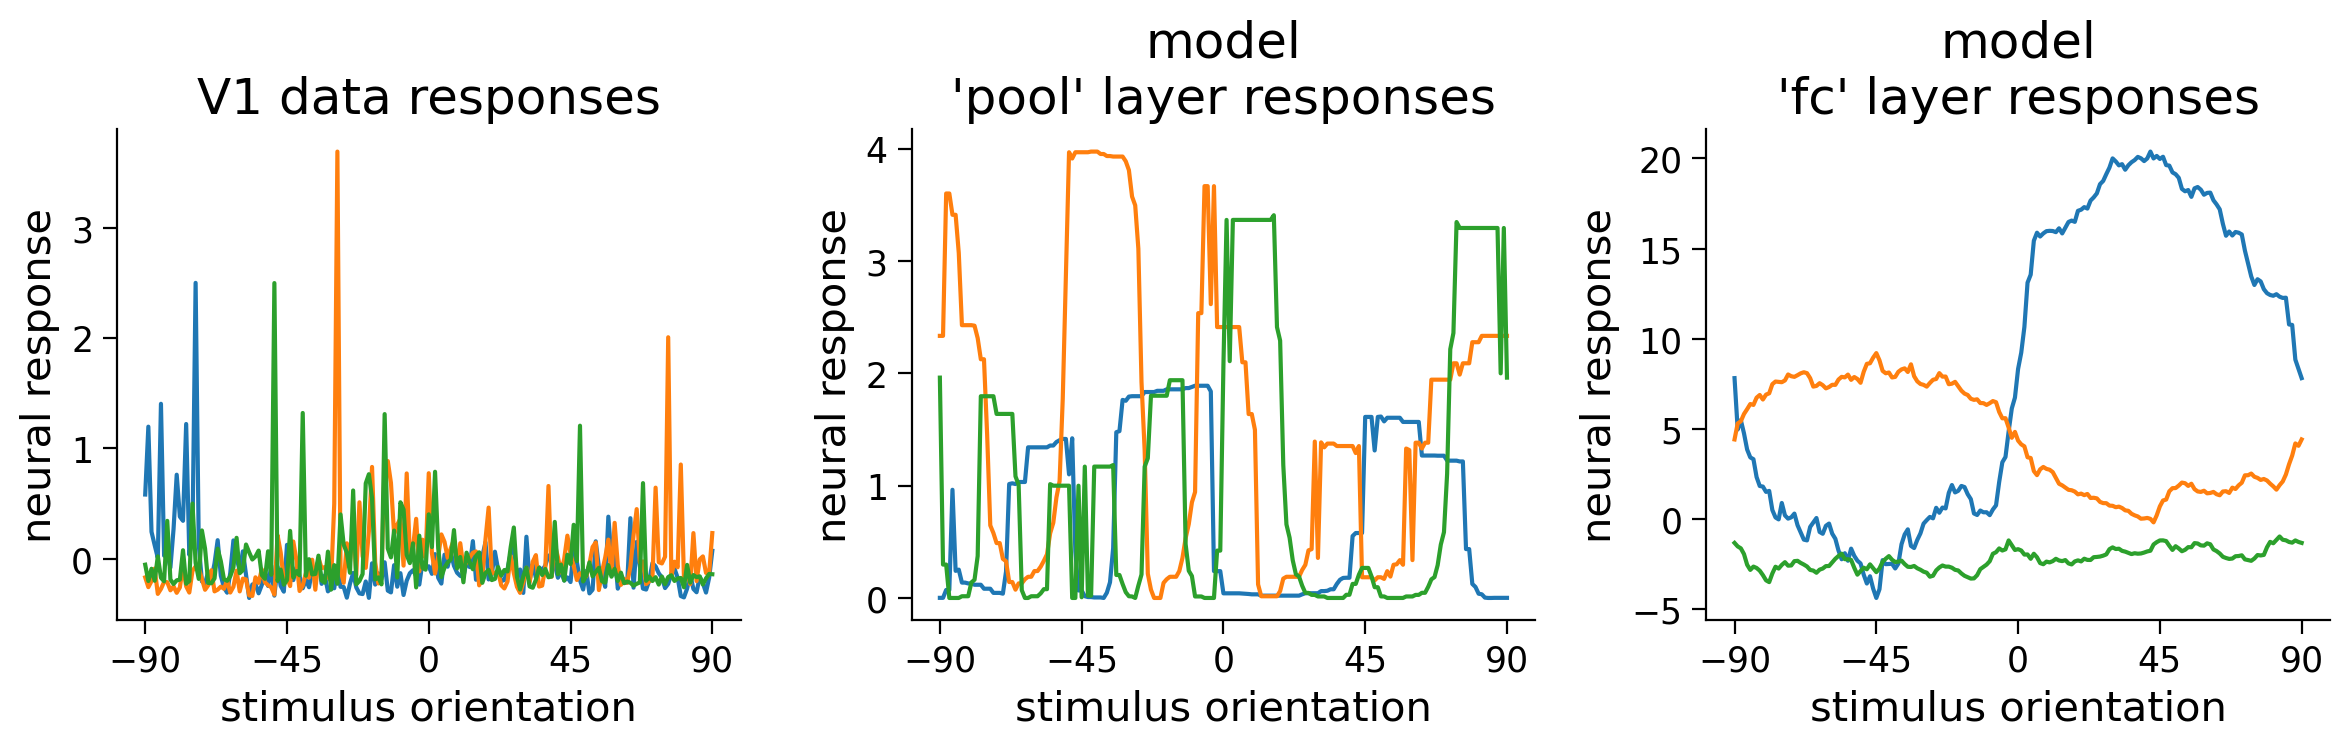

In [28]:
# @markdown Execute this cell to visualize tuning curves

fig, axs = plt.subplots(1, len(resp_dict), figsize=(len(resp_dict) * 4, 4))

for i, (label, resp) in enumerate(resp_dict.items()):

  ax = axs[i]
  ax.set_title(f'{label} responses')

  # Pick three random neurons whose tuning curves to plot
  ineurons = np.random.choice(resp.shape[1], 3, replace=False)

  # Plot tuning curves of ineurons
  ax.plot(ori, resp[:, ineurons])

  ax.set_xticks(np.linspace(-90, 90, 5))
  ax.set_xlabel('stimulus orientation')
  ax.set_ylabel('neural response')

plt.tight_layout()
plt.show()

In [33]:
pip install --upgrade scikit-learn numpy

^C
Traceback (most recent call last):
  File "/Users/benchen/anaconda3.bk/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/Users/benchen/anaconda3.bk/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/Users/benchen/anaconda3.bk/lib/python3.10/site-packages/pip/__main__.py", line 31, in <module>
    sys.exit(_main())
  File "/Users/benchen/anaconda3.bk/lib/python3.10/site-packages/pip/_internal/cli/main.py", line 70, in main
    return command.main(cmd_args)
  File "/Users/benchen/anaconda3.bk/lib/python3.10/site-packages/pip/_internal/cli/base_command.py", line 101, in main
    return self._main(args)
  File "/Users/benchen/anaconda3.bk/lib/python3.10/site-packages/pip/_internal/cli/base_command.py", line 216, in _main
    self.handle_pip_version_check(options)
  File "/Users/benchen/anaconda3.bk/lib/python3.10/site-packages/pip/_internal/cli/req_command.py", line 190, in handle_pip_vers

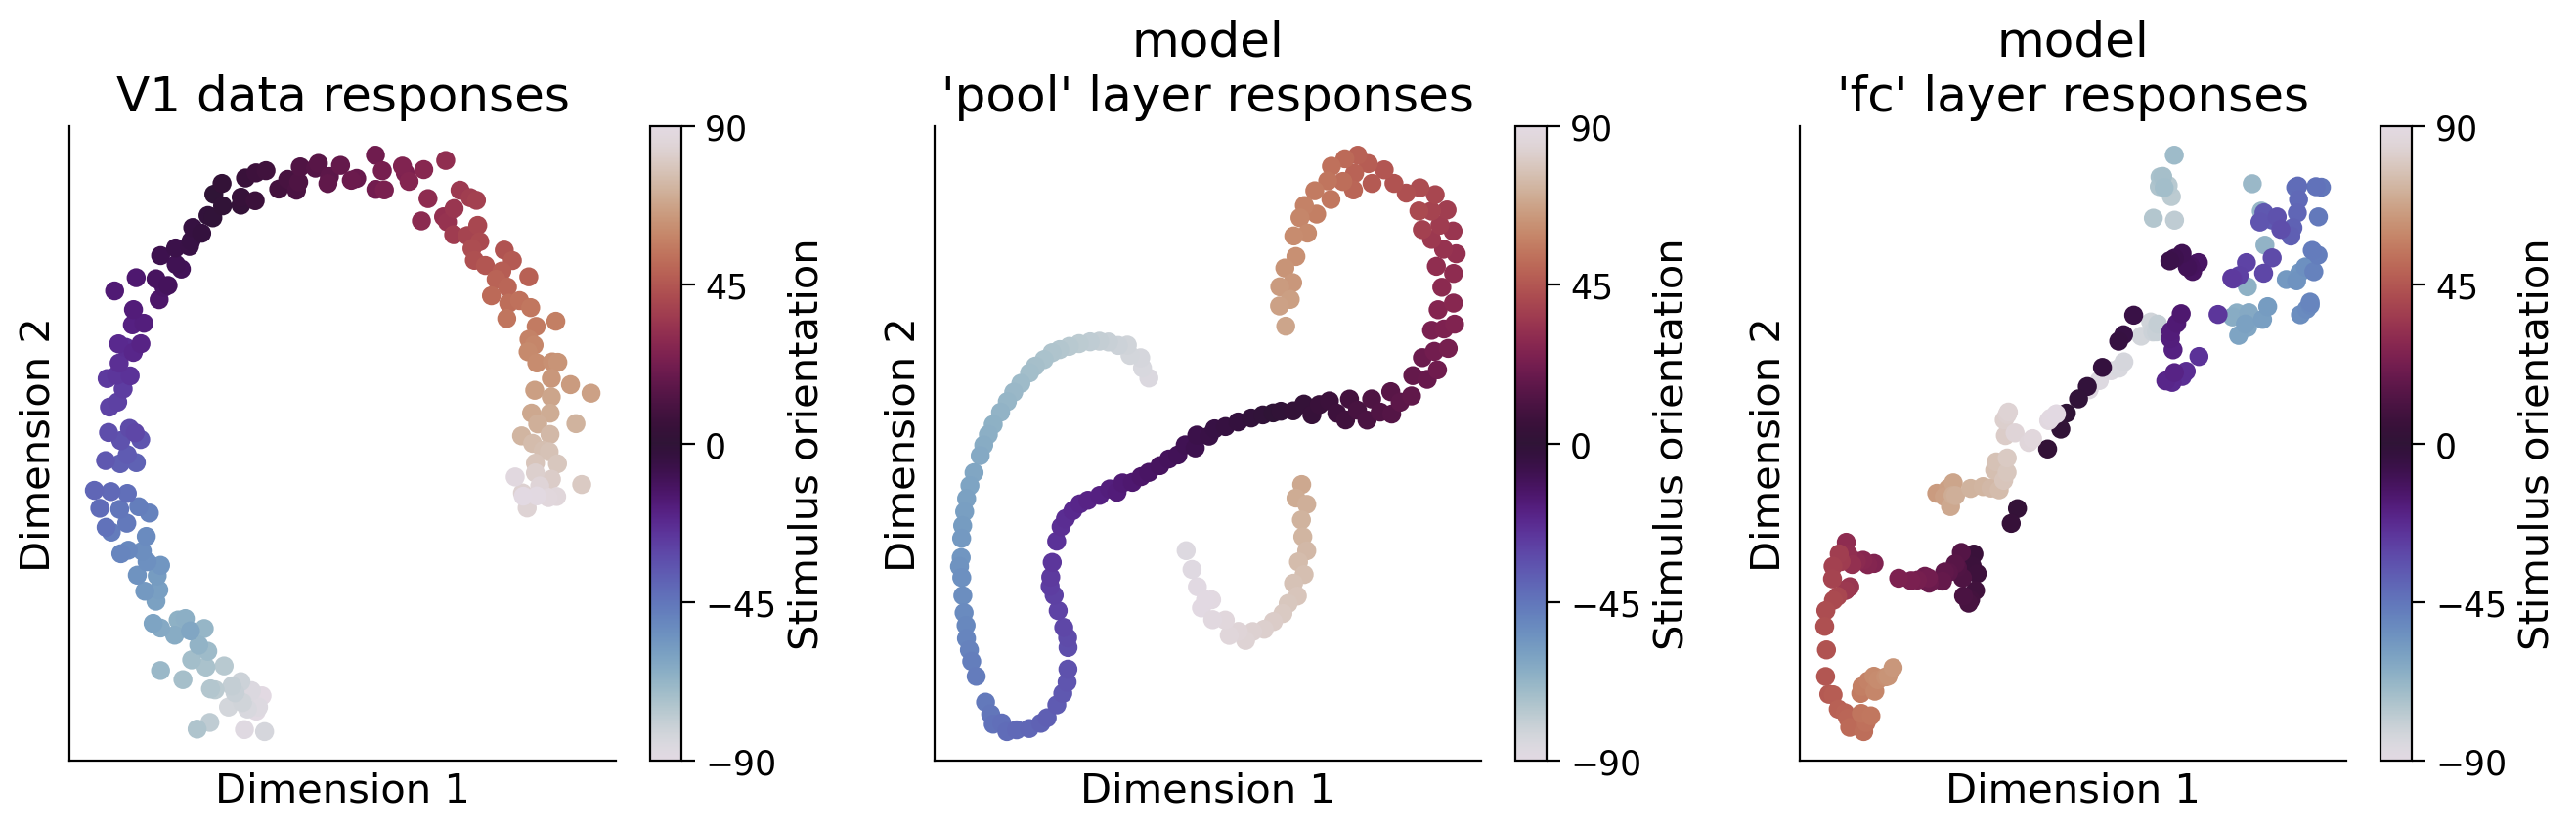

In [34]:
# @markdown Execute this cell to visualize low-d representations
def plot_resp_lowd(resp_dict):
  """Plot a low-dimensional representation of each dataset in resp_dict."""
  n_col = len(resp_dict)
  fig, axs = plt.subplots(1, n_col, figsize=(4.5 * len(resp_dict), 4.5))
  for i, (label, resp) in enumerate(resp_dict.items()):

    ax = axs[i]
    ax.set_title(f'{label} responses')

    # First do PCA to reduce dimensionality to 20 dimensions so that tSNE is faster
    resp_lowd = PCA(n_components=min(20, resp.shape[1]), random_state=0).fit_transform(resp)

    # Then do tSNE to reduce dimensionality to 2 dimensions
    resp_lowd = TSNE(n_components=2, random_state=0,method='exact').fit_transform(resp_lowd)

    # Plot dimensionality-reduced population responses 'resp_lowd'
    # on 2D axes, with each point colored by stimulus orientation
    x, y = resp_lowd[:, 0], resp_lowd[:, 1]
    pts = ax.scatter(x, y, c=ori, cmap='twilight', vmin=-90, vmax=90)
    fig.colorbar(pts, ax=ax, ticks=np.linspace(-90, 90, 5),
                 label='Stimulus orientation')

    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')
    ax.set_xticks([])
    ax.set_yticks([])
  plt.show()


plot_resp_lowd(resp_dict)

### Pooling layer vs Fully-connected layer
**Link to the explaintation**<br>
http://medium.com/@alejandro.itoaramendia/convolutional-neural-networks-cnns-a-complete-guide-a803534a1930#0dc2<br>
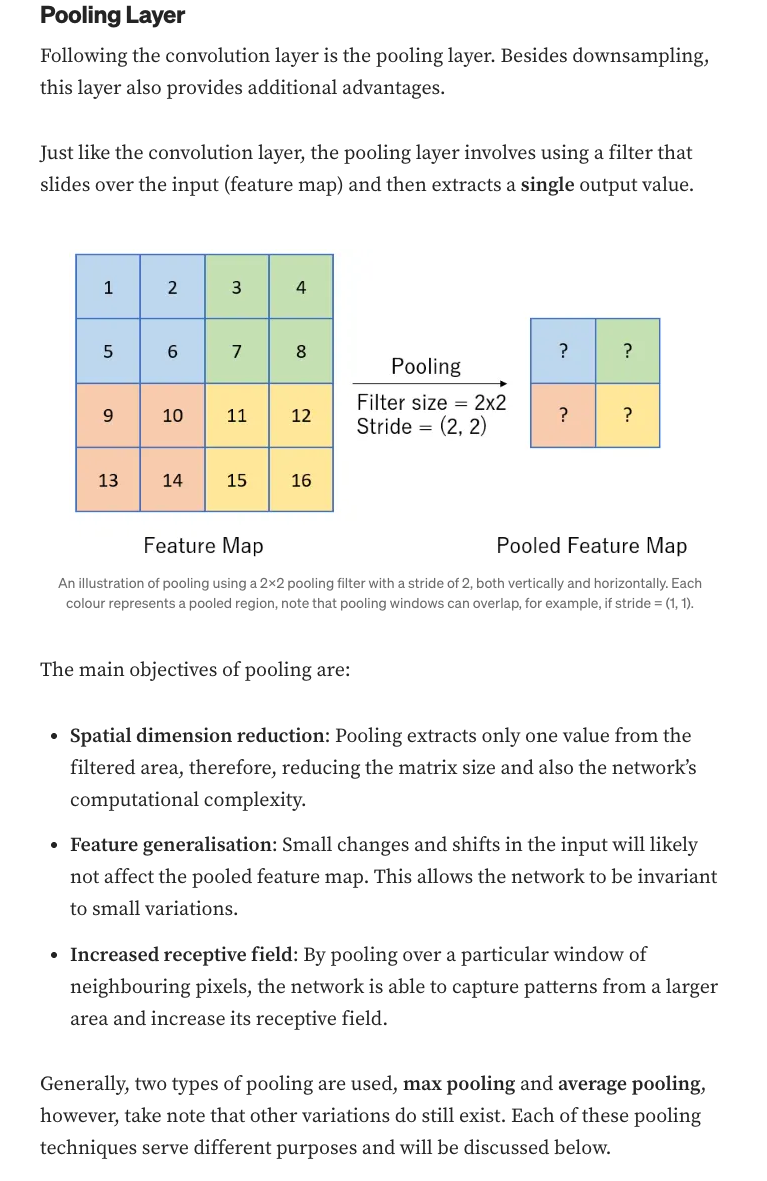
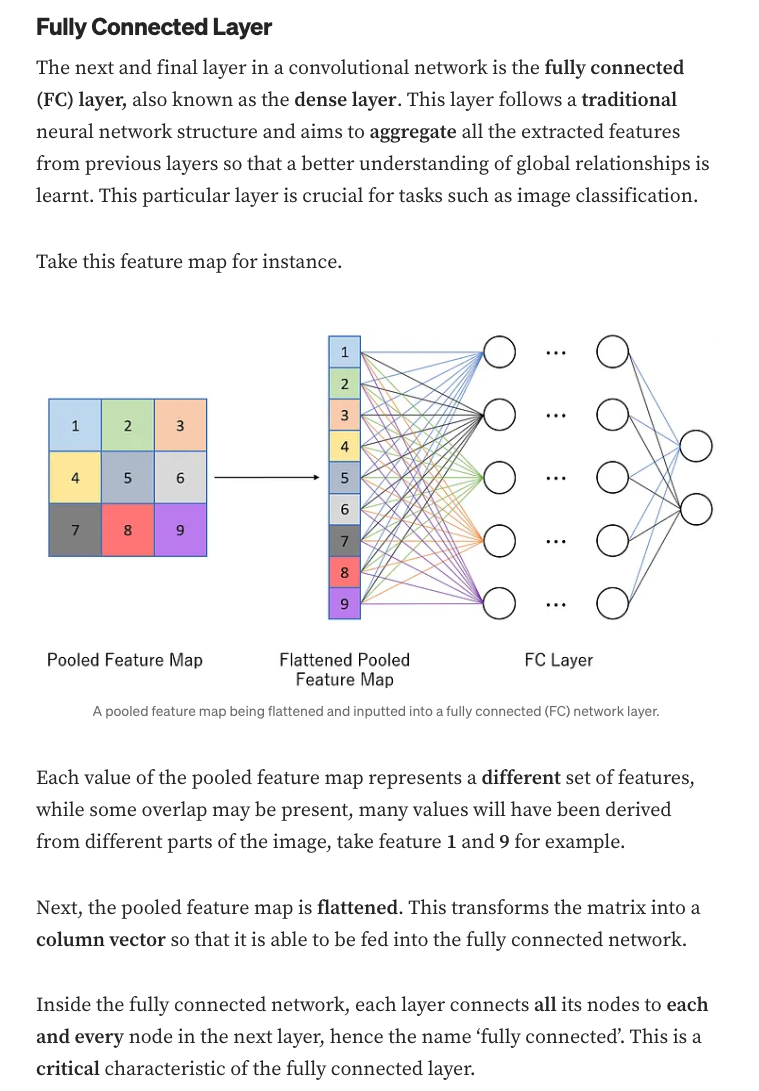